# PHAS0030 Assignment Week 7

In this notebook we will be performing a molecular dynamics simulation of the Lennard-Jones model of Neon. Using the parameters given to us in Section 5, *PHAS0030: Computational PhysicsSession 7: Modelling with Particles*.

These parameters being:

- $m_p = 1.673 \times 10^{-27}$ Kg
- $k_B = 1.380649 \times 10^{-23}$ Joules per Kelvin
- $\sigma = 0.275 \times 10^{-9}$ Metres
- $\epsilon = 36 kB$
- $m_{Ne} = 20.2 m_p$


In [1]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Set up the force function

In the following code cell we have oulined 3 functions.

The first function, `pbc` implements periodic boundary conditions for a particle.

The second function, `lennard_jones_energy` will use some of the parameters stated earlier in the notebook to then apply the Lennard-Jones potential equation:

$$
V(r) = 4 \epsilon [ (\frac{\sigma}{r})^{12} - ( \frac{\sigma}{r})^6]
$$

The thrid function, `lennard_jones_force` will also use some of the parameters stated earlier in the notebook to then apply the Lennard-Jones force equation:

$$
\vec{F}_i(\vec{r_{ij}}) = 24 \epsilon \hat{r_{ij}} [ \frac{\sigma^6}{r_{ij}^8} -  2 \frac{\sigma^{12}}{r_{ij}^{14}}] = - \vec{F}_j(\vec{r_{ij}})
$$

In [2]:
def pbc(r,boxlen):
    """
    Implements periodic boundary conditions for a particle
    
    Input:
    position = the position of the particles in three dimensions
    Npart = number of particles
    
    Output:
    Etot 
    """
    rout = r%boxlen
    return rout

def lennard_jones_energy(position, Npart, sigma, epsilon):
    """
    A function to calculate the Lennard-Jones potential energy for a set of 𝑁𝑃𝑎𝑟𝑡
    particles
    
    Input:
    position = the position of the particles in three dimensions
    Npart = number of particles
    sigma = constant
    epsilon = constant
    
    Output:
    Etot = the Lennard-Jones potential energy for a set of Npart particles
    """
    Etot = 0
    
    r = position
    
    for i in range(Npart-1):
        for j in range(i+1,Npart):
            
            rij = r[j] - r[i]
            r_ij_mag_sqrd = np.sum(rij*rij)
            
            # Lennard-Jones potential formula
            V_rij = 4*epsilon*(((sigma**12)/(r_ij_mag_sqrd**6)) - ((sigma**6)/(r_ij_mag_sqrd**3)))
            
            Etot = Etot + V_rij
    
    return Etot

def lennard_jones_force(position, Npart, sigma, epsilon, boxlen):
    """
    A function to calculate the Lennard-Jones forse for a set of Npart
    particles
    
    Input:
    position = the position of the particles in three dimensions
    Npart = number of particles
    sigma = constant
    epsilon = constant
    
    Output:
    Ftot = the Lennard-Jones total force for a set of Npart particles
    """
    Ftot = np.zeros((Npart, 3))
    
    r = position
    
    for i in range(Npart-1):
        for j in range(i+1,Npart):
            
            rij = r[j] - r[i]
            rij -= boxlen*np.rint(rij/boxlen)
            r_ij_mag_sqrd = np.sum(rij*rij)
            
            # Lennard-Jones force formula
            F_rij = 24*epsilon*rij*(((sigma**6)/(r_ij_mag_sqrd**4)) - 2*((sigma**12)/(r_ij_mag_sqrd**7)))
            
            Ftot[i] += F_rij
            Ftot[j] -= F_rij
            
    return Ftot

### 2. Set up the lattice and the simulation parameters



In [3]:
# Initialisation
Nsteps = 10000 # Number of time steps

m_p = 1.673 * 10**(-27) # Kg
kB = 1.380649 * 10**(-23) # Joules per Kelvin
sigma = 0.275 * 10**(-9) # Metres
epsilon = 36*kB
mass = 20.2*m_p # Mass of a Neon atom

Npart = 64 # Number of Ne atoms
Ncells = int(np.cbrt(Npart)) # Number of cells along each of the 3 spatial dimensions
boxlen = 1.1*(2**(1/6))*sigma*Ncells # Length of box of our lattice

# Initialising Displacement and Velocity arrays for lattice
rbox3 = np.zeros((Nsteps, Npart, 3))
vbox3 = np.zeros((Nsteps, Npart, 3))

# For loop to calculate the starting position of all our atoms
part_no = 0
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,part_no,:] = (boxlen/Ncells) * np.array([i, j, k])
            part_no += 1

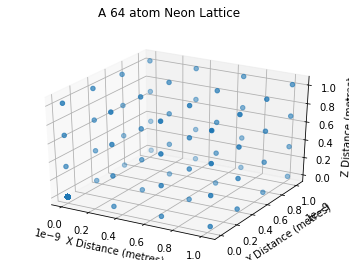

In [4]:
# Plot the lattice
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Retrieving positions
x_pos = rbox3[:,:,0]
y_pos = rbox3[:,:,1]
z_pos = rbox3[:,:,2]

fig.suptitle("A " + str(Npart) + " atom Neon Lattice")
ax.scatter(x_pos, y_pos, z_pos)
ax.set_xlabel('X Distance (metres)')
ax.set_ylabel('Y Distance (metres)')
ax.set_zlabel('Z Distance (metres)')
plt.show()

### 3. Initialise velocities

In this code cell below we have initialised our velocities using a random value from a normal distribution function, which has been scaled.

We have also initialised our mean squared displacement, acceleration and all other arrays and values which we will be using later on.

In [5]:
# Initialise velocities
initT = 50          # K
# The initial distribution can have an arbitrary scaling
vbox3[0] = np.random.normal(size=(Npart,3))

# These line rescales the velocities
vsig = np.sqrt(kB*initT/mass)
vbox3[0] = np.random.normal(scale=vsig, size=(Npart,3))

# Initialising energy and temperature arrays
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)

# Calculating first element of energy and temperature arrays
e = lennard_jones_energy(rbox3[0,:,:], Npart, sigma, epsilon)
f = lennard_jones_force(rbox3[0,:,:], Npart, sigma, epsilon, boxlen)

energy[0] = e
temp[0] = initT

# Setting initial acceleration, mean squared displacement, and time step
acc = f/mass
dt = 1e-15 # time step, seconds
MSD = np.zeros(Nsteps)

### 4. Run simulation


In this code cell below we have created a for loop that is using the functions we initially declared to calculate the position, velocity, mean-squared displacement, force, energy, and temperature at every time step and store them in arrays.

It is also important to note that the mean-squared displacement is defined as:

$$
D(t) = \frac{1}{N} \sum^N_{i = 1}{(r_{i}(t) - r_{i}(0))^2}
$$

In [6]:
for step in range(1,Nsteps):
    
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc
    
    # Periodic boundaries
    rbox3[step] = pbc(rbox3[step],boxlen)
    
    #energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    energy[step] = lennard_jones_energy(rbox3[step,:,:], Npart, sigma, epsilon)
    f = lennard_jones_force(rbox3[step,:,:], Npart, sigma, epsilon, boxlen)
    
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    
    # Calculate mean-squared displacement
    MSD[step] = np.sum((rbox3[step] - rbox3[0])**2)

MSD /= Npart

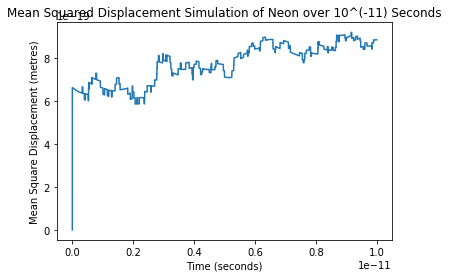

In [7]:
# Time array created
timeaxis = np.linspace(0,Nsteps*dt - dt,Nsteps)

# Plotting Mean Squared Displacement
plt.title("Mean Squared Displacement Simulation of Neon over 10^(-11) Seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Square Displacement (metres)")
plt.plot(timeaxis,MSD)
plt.show()

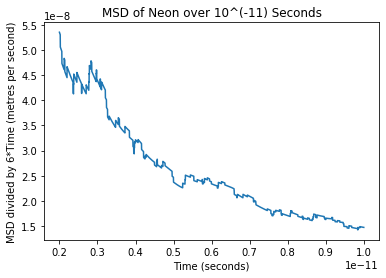

In [17]:
# Slicing arrays
MSD_2ps = MSD[2000:]
time_2ps = timeaxis[2000:]
MSD_6t = MSD_2ps/(6*time_2ps)

# Plotting Mean Squared Displacement divided by 6*Time
plt.title("MSD of Neon over 10^(-11) Seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("MSD divided by 6*Time (metres per second)")
plt.plot(time_2ps,MSD_6t)
plt.show()

### 5. Calculate the integral

In [9]:
# Numerical rectangle integration
Int = np.zeros(Nsteps)

for step in range(1,Nsteps):
    # Calculating the individual terms for a dot product and
    # then summing
    x_term = np.sum(vbox3[step,:,0]*vbox3[0,:,0])
    y_term = np.sum(vbox3[step,:,1]*vbox3[0,:,1])
    z_term = np.sum(vbox3[step,:,2]*vbox3[0,:,2])
    
    # Adding all the terms from the dot product to the next entry
    # of the auto-correlation array.
    Int[step] = Int[step-1] + (x_term + y_term + z_term)*dt

Int = Int/(3*Npart)

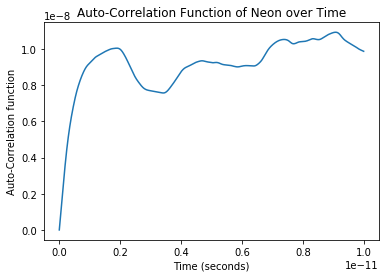

In [10]:
# Plot the auto-correlation function
plt.title("Auto-Correlation Function of Neon over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Auto-Correlation function")
plt.plot(timeaxis,Int)
plt.show()

## Conclusion

In [25]:
# Estimating the converged value from Q5
MSD_conv = np.mean(MSD_6t[-500:])

# Estimating the converged value from Q6
Int_conv_array = Int[-500:]/6
Int_conv = np.mean(Int_conv_array)

print("MSD_conv: " + str(MSD_conv))
print("Int_conv: " + str(Int_conv))

MSD_conv: 1.477062998893596e-08
Int_conv: 1.6841441734788165e-09


As we can see in the cell above these 2 values do infact converge and are very similar to one another. Confirming that our simulation is correct. The effort required to calculate the value from the auto-correlation function was minimal in comparison to the other simlulation which took much longer. They are roughly a factor of 10 out.